In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/OptimizerRhoOmega.py:360: SyntaxWarning:

invalid escape sequence '\p'



In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### 1. Lectura de datos

In [4]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(os.path.join(cwd, 'data'), 'ocean')
data = np.load(os.path.join(data_path, 'VES3.npy'))
freq = np.load(os.path.join(data_path, 'freq.npy'))

print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(14376, 171, 1)


(171,)


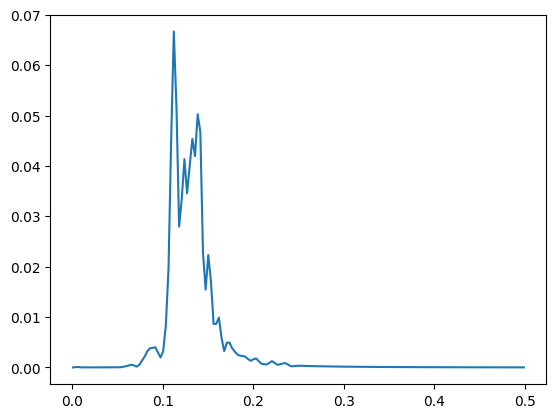

In [5]:
print(freq.shape)
plt.plot(freq, data[0,:,0])
plt.show()

### Se cogen solo los datos de un año natural

In [6]:
# Fechas de inicio y finalización
start_date = datetime(2019, 6, 25)
end_date = datetime(2021, 2, 12)

# Lista para guardar las fechas en formato cadena
dates = []

# Generar fechas y horas
current_date = start_date
while current_date <= end_date:
    for hour in range(24):  # 24 horas por día
        formatted_date = current_date.replace(hour=hour).strftime("%Y-%m-%d")
        dates.append(formatted_date)
    current_date += timedelta(days=1)

data_2 = data.reshape(num_samples, num_obs_per_sample)
data_2 = pd.DataFrame(data_2)
data_2['fecha'] = dates

data_2['fecha'] = pd.to_datetime(data_2['fecha'])

data = data_2[data_2['fecha'].dt.year == 2020]
data = data.drop(columns='fecha')
data = data.to_numpy()
data = data[:, :, np.newaxis]

In [7]:
print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(8784, 171, 1)


(171,)


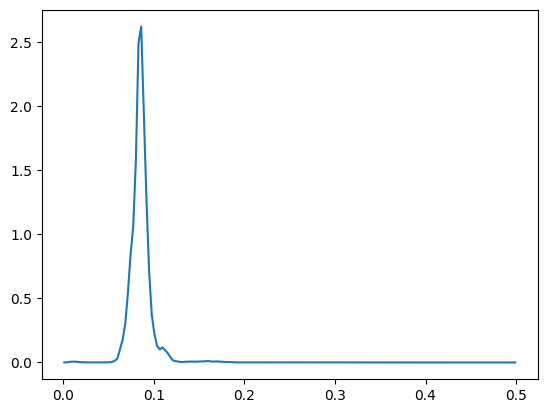

In [8]:
print(freq.shape)
plt.plot(freq, data[0,:,0])
plt.show()

In [9]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=50)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 1e-3
std_dif = std_dif * 1e-3
bound_sigma = (std * 1e-3, std * 1.0)
bound_gamma = (std_dif * 1e-3, std_dif * 1.0)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.008764265286646068
Gamma estimated: 0.008764265286646068
Final sigma: 8.764265286646069e-06
Final gamma: 8.764265286646069e-06
Final sigma bound: (8.764265286646069e-09, 8.764265286646069e-06)
Final gamma bound: (8.764265286646069e-09, 8.764265286646069e-06)


In [10]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M

In [11]:
outputscale_ = 0.1
ini_lengthscale = 1e-4
bound_lengthscale = (1e-7, 1e-3)

In [12]:
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq).T
x_train = np.atleast_2d(freq).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False

(171, 1)


In [13]:
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

In [14]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, estimation_limit=30)

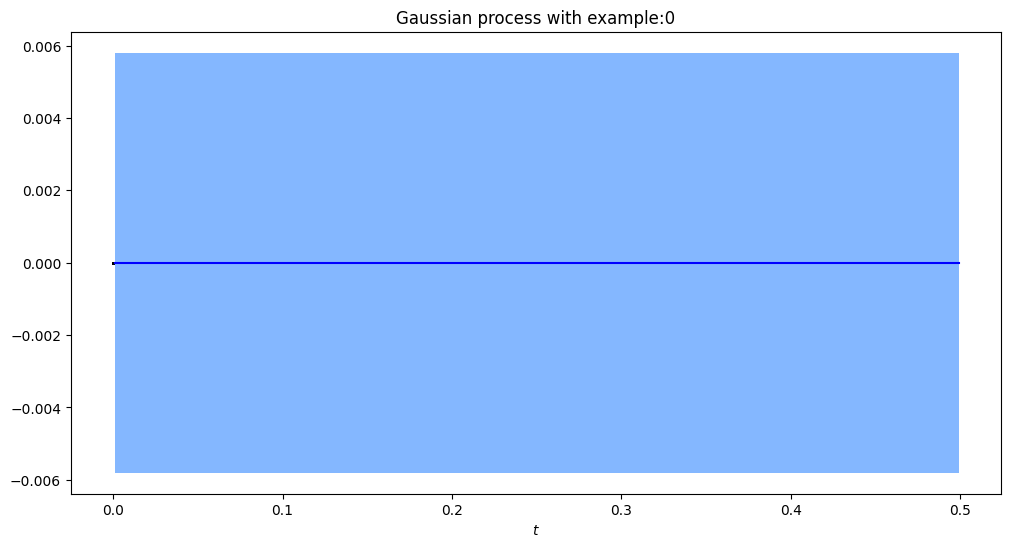

In [15]:
sw_gp.gpmodels[0][0].plot_last(0)

In [16]:
data_ = data[:,:,[0]]
sw_gp.include_sample(x_train, data_[0], with_warp=warp)

Main model chosen: 1

 Fitting_GP: 

Iter 1/4000 - Loss: 12592.632
Iter 501/4000 - Loss: -0.524
Iter 1001/4000 - Loss: -0.546
Iter 1501/4000 - Loss: -0.586
Iter 2001/4000 - Loss: -0.661
Iter 2501/4000 - Loss: -0.830
Iter 3001/4000 - Loss: -1.165


Parameter name: likelihood.noise_covar.raw_noise           value = [2.58787098]
Parameter name: mean_module.raw_constant                   value = 0.08646353963694606
Parameter name: covar_module.raw_outputscale               value = -2.3857663993769953
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-5.31917073]]


In [17]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

Kernel estimated: 0.297**2 * RBF(length_scale=0.00488) + WhiteKernel(noise_level=8.15e-06)
Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


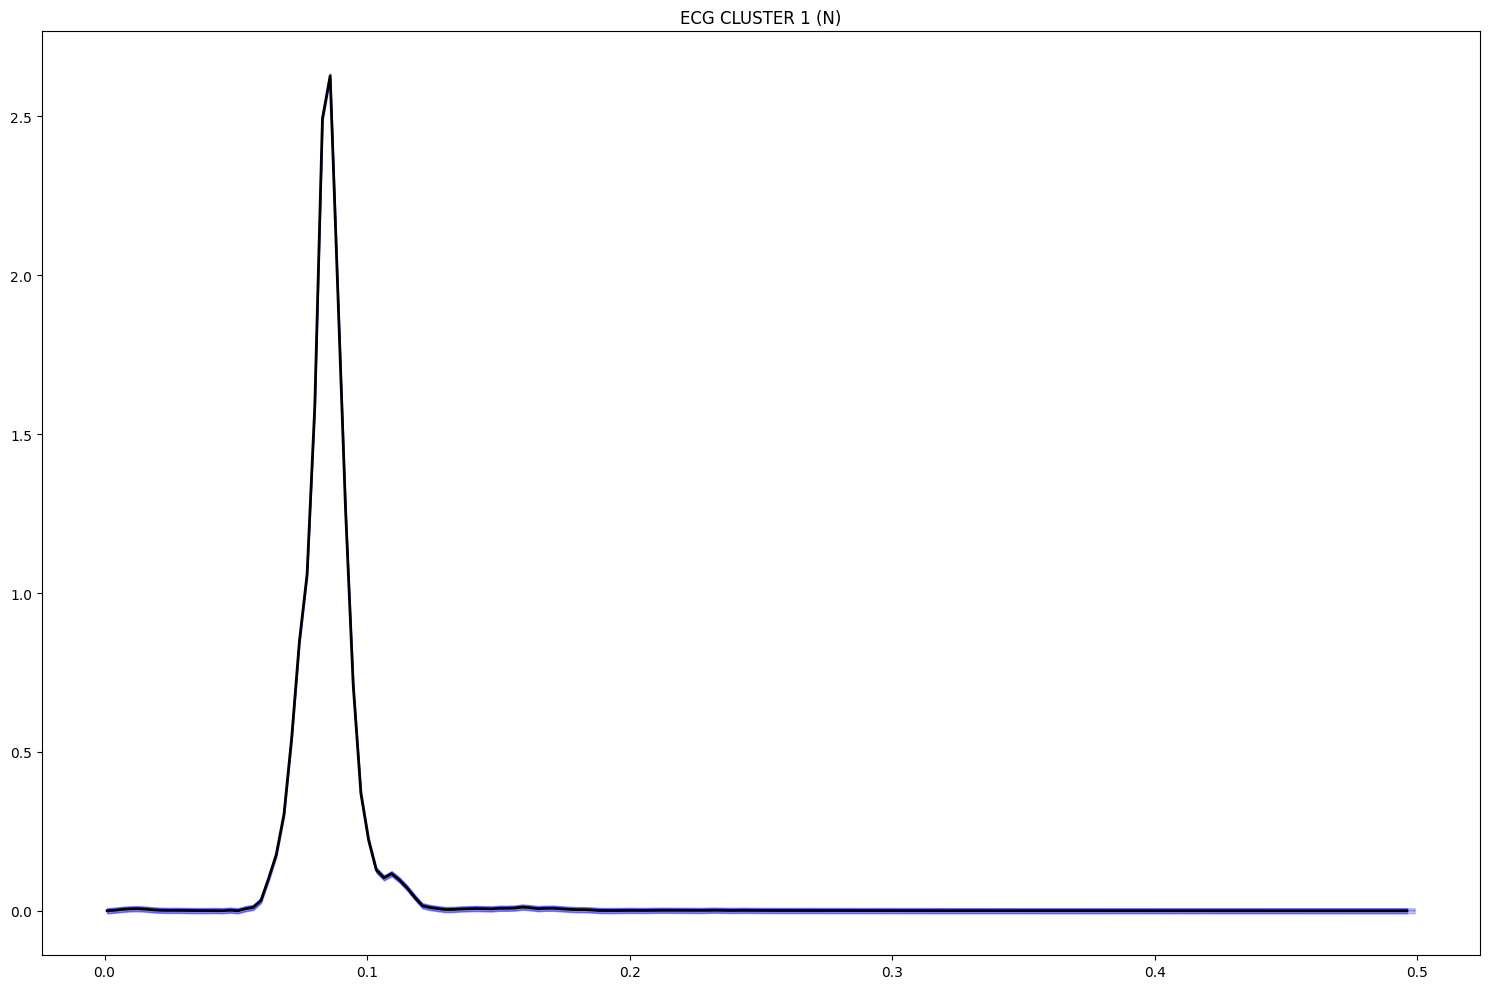

In [18]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

Kernel estimated: 0.297**2 * RBF(length_scale=0.00488) + WhiteKernel(noise_level=8.15e-06)
Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


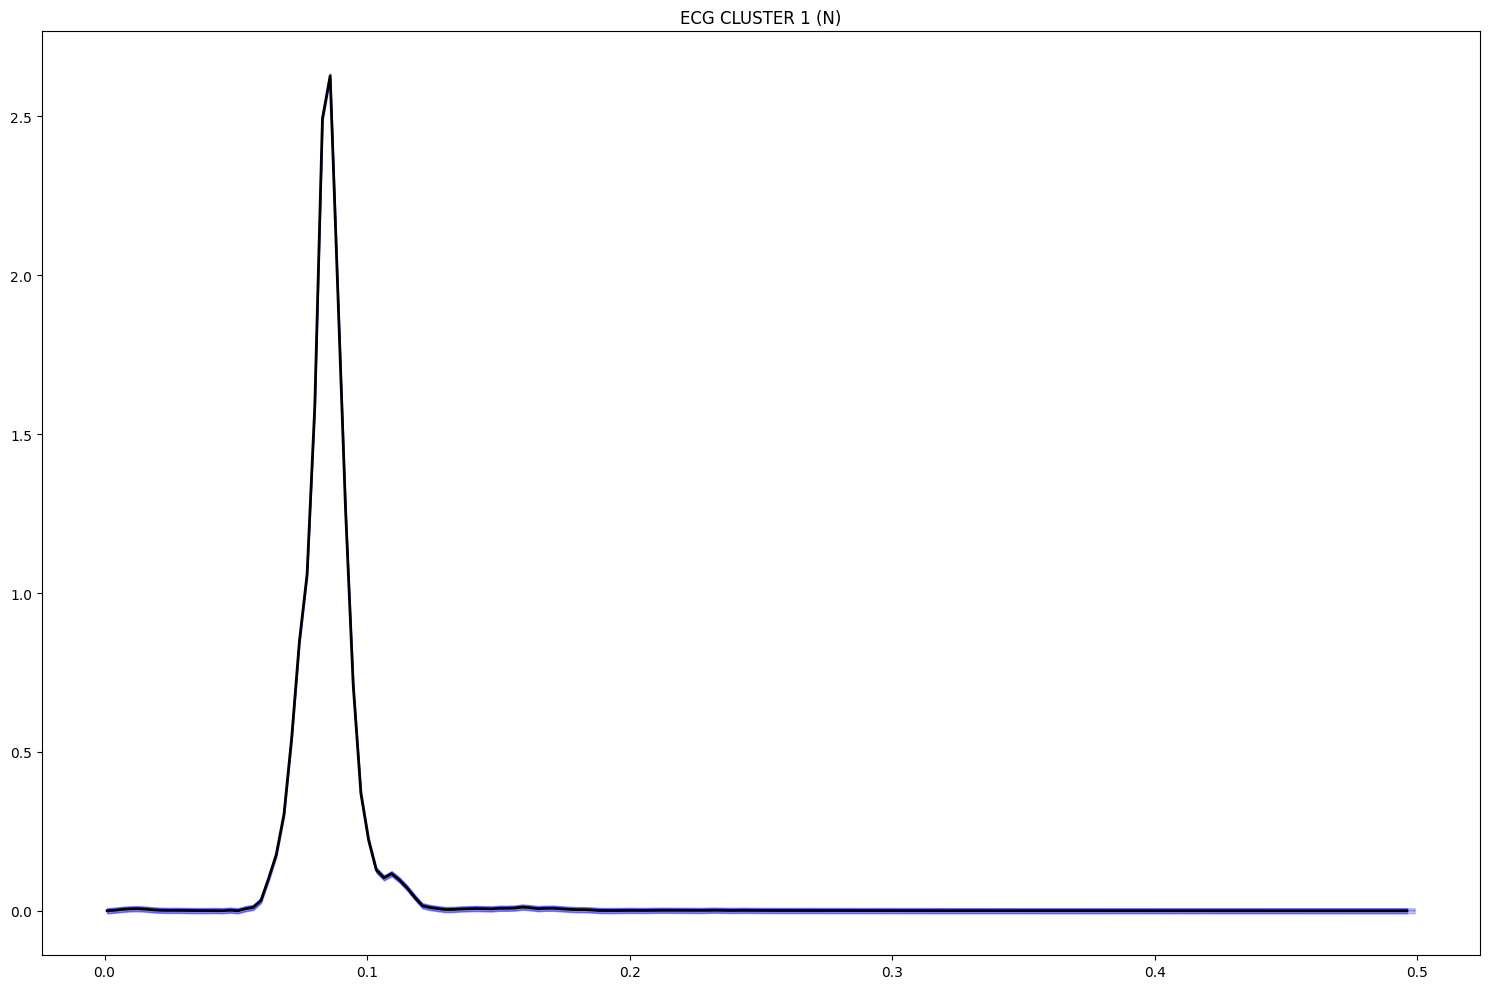

In [19]:
print("Kernel estimated:", sw_gp.gpmodels[0][0].gp.kernel)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
labels = np.array(['N'] * data.shape[0])
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, labels, main_model, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True)

Model 1 : MainModel: N : [N-1]
Model 2  : []
Classification error:  0.0 / 1 -- 0.0


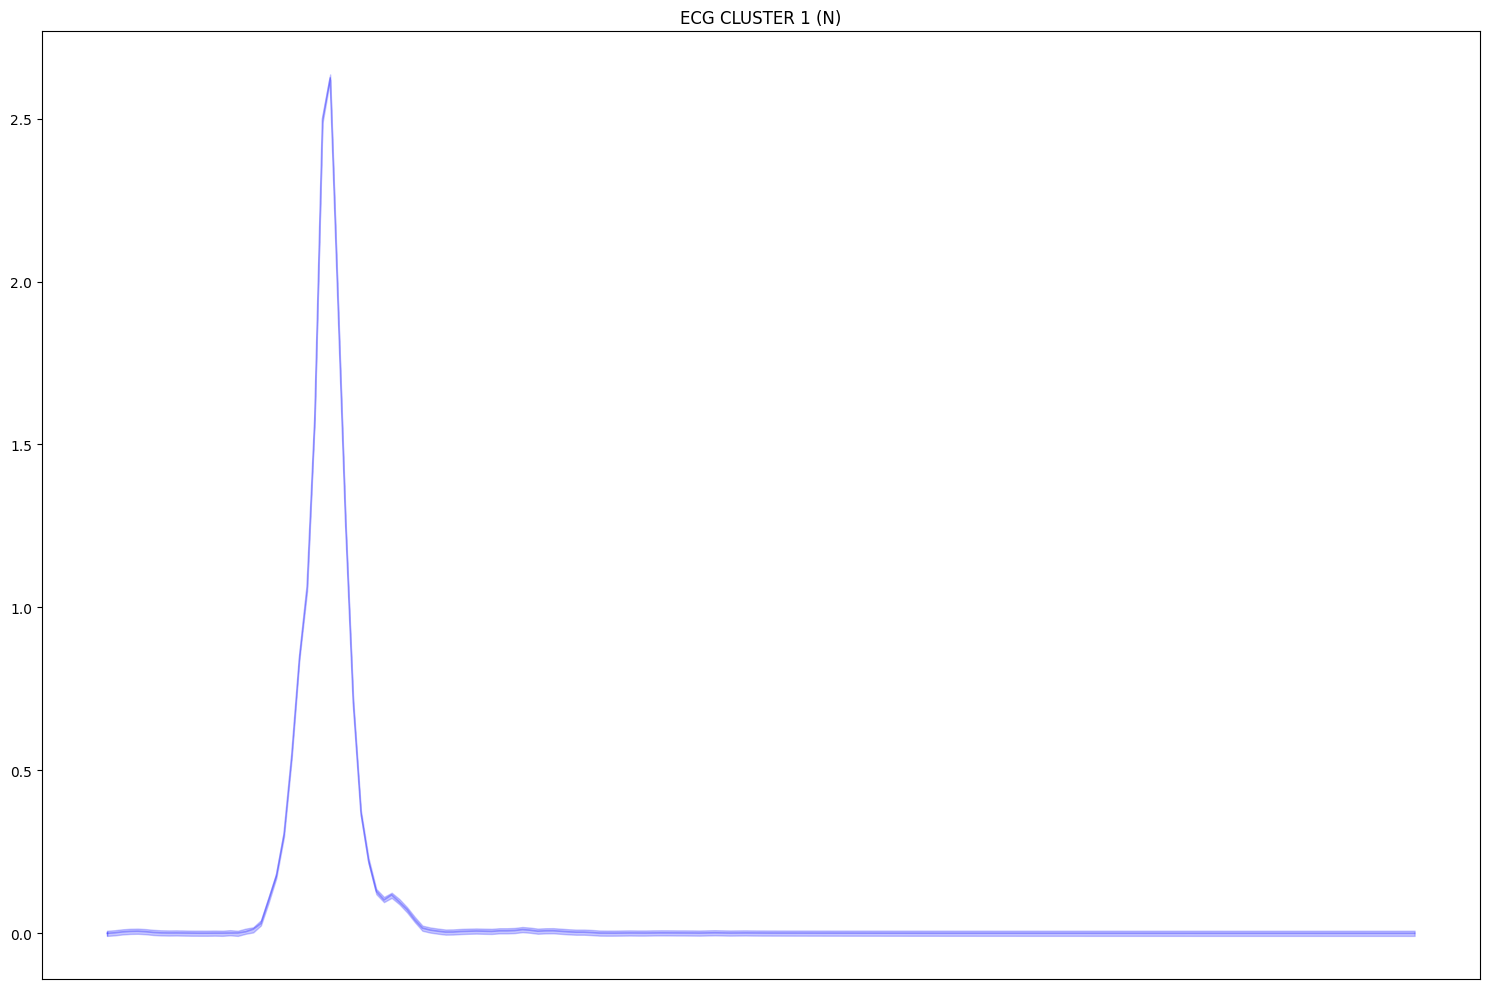

In [20]:
from hdpgpc.util_plots import print_results, plot_models_plotly

main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=0.5, plot_latent=True)

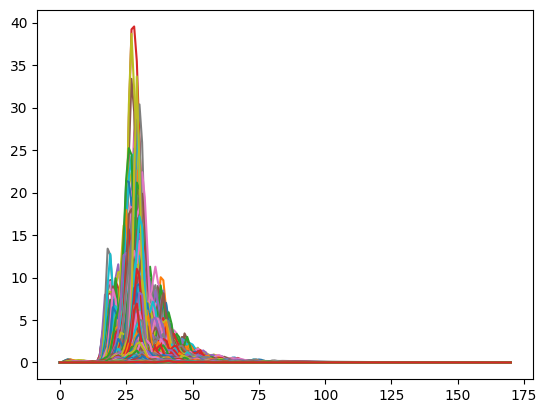

In [21]:
data_ = data[:,:,[0]]
plt.plot(data_[:,:,0].T)
plt.show()

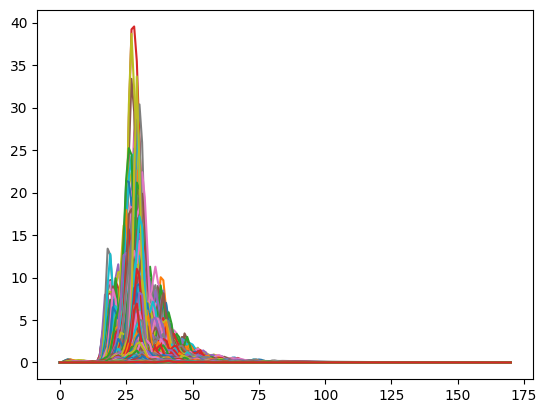

In [22]:
data_ = data[:,:,[0]]
plt.plot(data_[:,:,0].T)
plt.show()

In [23]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=True, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=5)

num_samples = data.shape[0]
x_trains = np.array([x_train] * 200)
sw_gp.include_batch(x_trains, data[:200,:,[0]])

Group responsability estimated: [200   0]


Forward_pass:   0%|          | 0/200 [00:00<?, ?it/s]


 Fitting_GP: 

Iter 1/4000 - Loss: 12592.632
Iter 501/4000 - Loss: -0.524
Iter 1001/4000 - Loss: -0.546
Iter 1501/4000 - Loss: -0.586
Iter 2001/4000 - Loss: -0.661
Iter 2501/4000 - Loss: -0.830
Iter 3001/4000 - Loss: -1.165


Forward_pass:   4%|▍         | 9/200 [00:13<03:31,  1.11s/it]



Parameter name: likelihood.noise_covar.raw_noise           value = [2.58787098]
Parameter name: mean_module.raw_constant                   value = 0.08646353963694606
Parameter name: covar_module.raw_outputscale               value = -2.3857663993769953
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[-5.31917073]]


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 793.12it/s]



-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 622.52it/s]


Step 1/5- Trying to divide: 0 with beat 174


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 697.72it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17248.3885), Q_lat: tensor(-1059054.3487), Elbo_post: tensor([-1051738.9998])
Possibly better q_obs but worse elbo.
Step 2/5- Trying to divide: 0 with beat 179


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 768.71it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17348.0852), Q_lat: tensor(-788012.4651), Elbo_post: tensor([-780698.1940])
Possibly better q_obs but worse elbo.
Step 3/5- Trying to divide: 0 with beat 176


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 730.70it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17348.1772), Q_lat: tensor(-725777.8251), Elbo_post: tensor([-718463.4390])
Possibly better q_obs but worse elbo.
Step 4/5- Trying to divide: 0 with beat 171


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 816.69it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17491.1289), Q_lat: tensor(-1083127.8945), Elbo_post: tensor([-1075816.4661])
Possibly better q_obs but worse elbo.
Step 5/5- Trying to divide: 0 with beat 178


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 868.07it/s]


Sum resp_temp: tensor([190.,  10.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17143.0385), Q_lat: tensor(-747751.9116), Elbo_post: tensor([-740410.4036])
Possibly better q_obs but worse elbo.
First resp: tensor([200.,   0.])
Mean_sq: tensor(-18312.0278)
ELBO: tensor([-71955.4299])

-------Lower Bound Iteration 1-------
Group responsability estimated: [200   0]

-----------Lead 1-----------


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 642.22it/s]


Step 1/5- Trying to divide: 0 with beat 174


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 809.58it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17248.3885), Q_lat: tensor(-1059054.3487), Elbo_post: tensor([-1051757.7548])
Possibly better q_obs but worse elbo.
Step 2/5- Trying to divide: 0 with beat 179


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 785.01it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17348.0852), Q_lat: tensor(-788012.4651), Elbo_post: tensor([-780716.9491])
Possibly better q_obs but worse elbo.
Step 3/5- Trying to divide: 0 with beat 176


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 678.82it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17348.1772), Q_lat: tensor(-725777.8251), Elbo_post: tensor([-718482.1941])
Possibly better q_obs but worse elbo.
Step 4/5- Trying to divide: 0 with beat 171


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 707.04it/s]


Sum resp_temp: tensor([192.,   8.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17491.1289), Q_lat: tensor(-1083127.8945), Elbo_post: tensor([-1075835.2212])
Possibly better q_obs but worse elbo.
Step 5/5- Trying to divide: 0 with beat 178


Compute_sq_error: 100%|██████████| 200/200 [00:00<00:00, 742.77it/s]


Sum resp_temp: tensor([190.,  10.])
Q_bas: tensor(-18312.0278), Q_lat: tensor(-60899.0884), Elbo_bas: tensor([-53643.4021])
Q_bas_post: tensor(-17143.0385), Q_lat: tensor(-747751.9116), Elbo_post: tensor([-740429.6140])
Possibly better q_obs but worse elbo.
First resp: tensor([200.,   0.])
Mean_sq: tensor(-18312.0278)
ELBO: tensor([-71955.4299])

-------Lower Bound Iteration 2-------


In [25]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(os.path.join(cwd, 'data'), 'ocean')
data = np.load(os.path.join(data_path, 'VES3.npy'))
freq = np.load(os.path.join(data_path, 'freq.npy'))

print("Shape of the data: ")
print(data.shape)
num_samples, num_obs_per_sample, num_outputs = data.shape

with open('sw_gp.pkl', 'rb') as file:
    load_sw_gp = pickle.load(file)
    
labels = np.array(['N'] * data.shape[0])

Shape of the data: 
(14376, 171, 1)


FileNotFoundError: [Errno 2] No such file or directory: 'sw_gp.pkl'

In [51]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from 'C:\\Users\\marco\\OneDrive - Universidade de Santiago de Compostela (1)\\CITIUS\\HDP-GPC\\hdpgpc\\hdpgpc\\util_plots.py'>

Model 1 : MainModel: N : [N-200]
Model 2  : []
Classification error:  0.0 / 200 -- 0.0


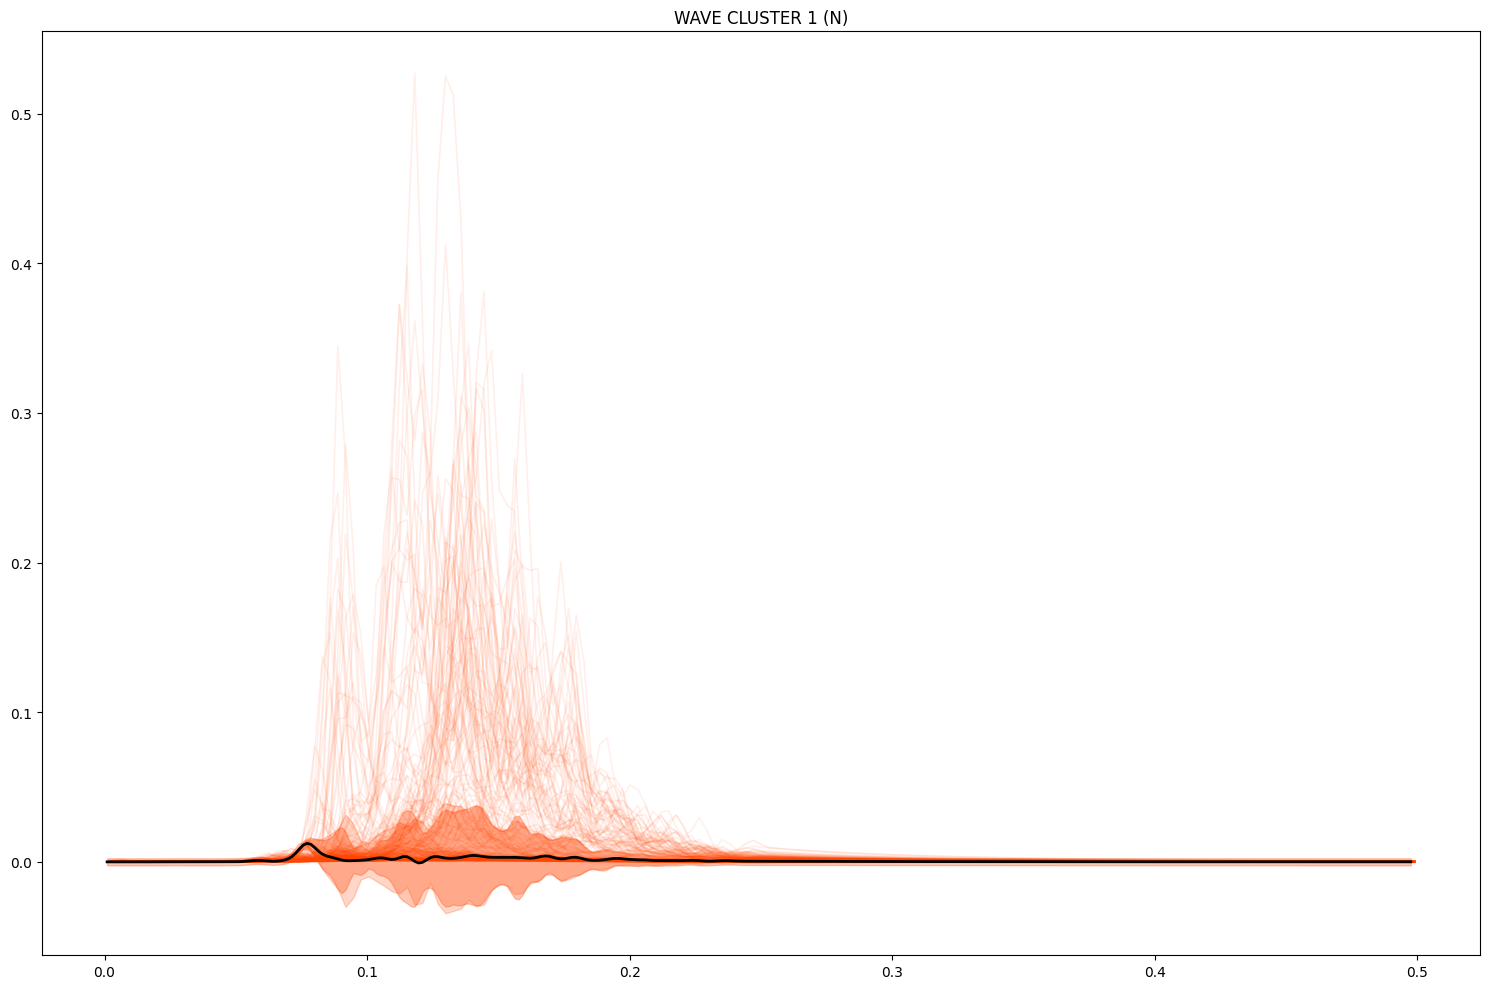

In [68]:
labels = np.array(['N'] * 200)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
up.plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq[1]-freq[0])/2, 
                   plot_latent=True, title='WAVE CLUSTER',ticks=True)

Model 1 : MainModel: N : [N-200]
Model 2  : []
Classification error:  0.0 / 200 -- 0.0


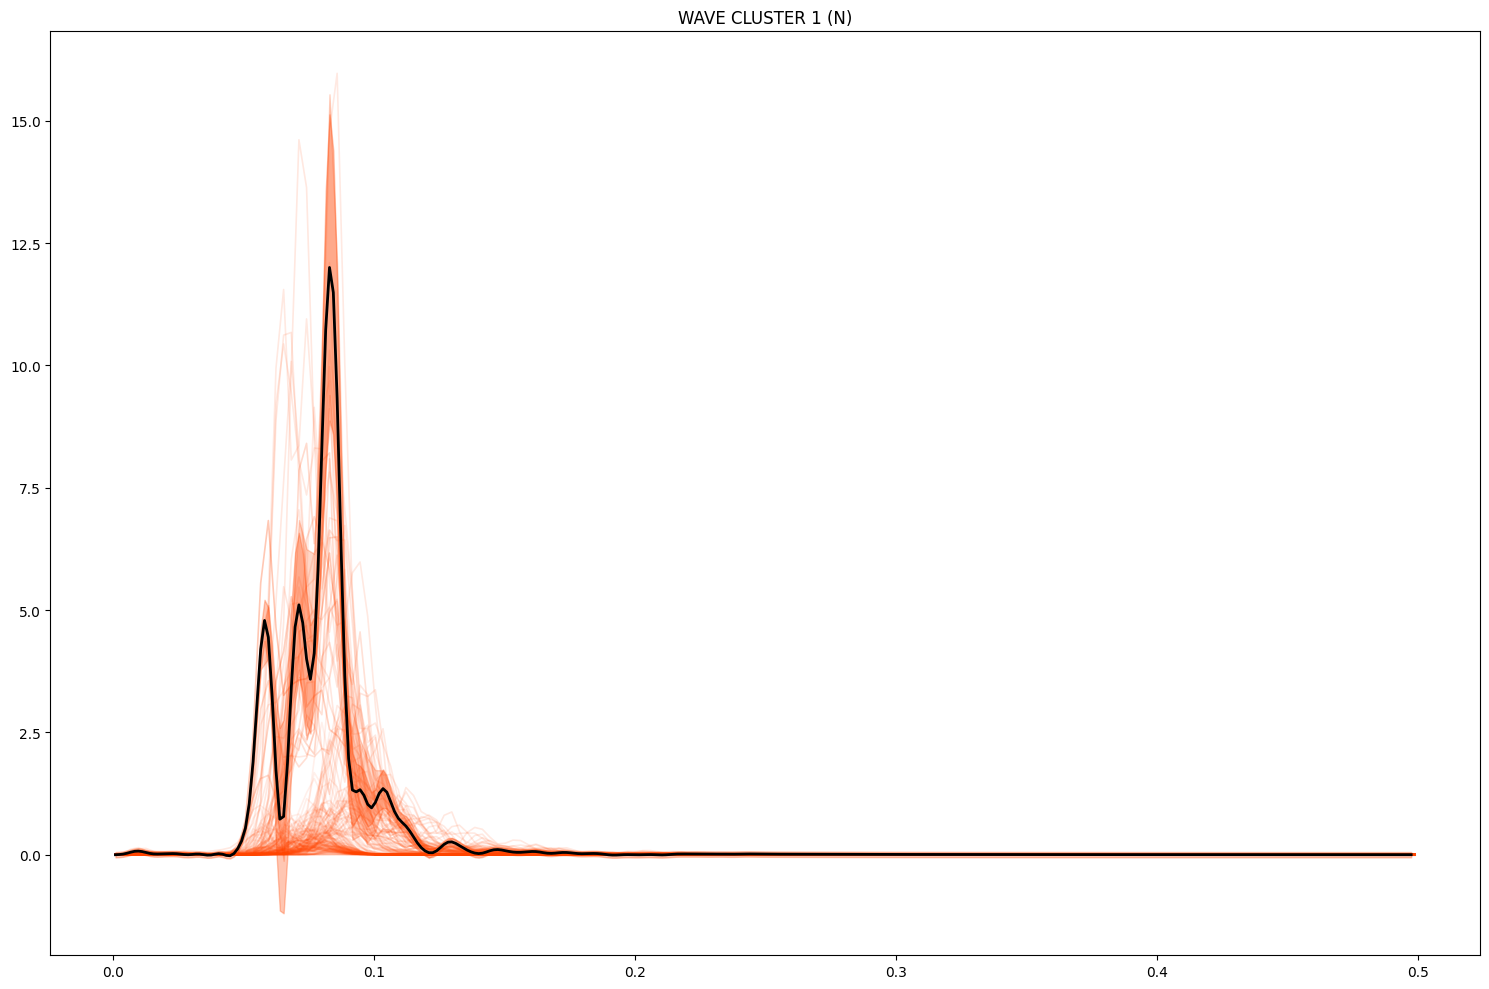

In [144]:
labels = np.array(['N'] * 200)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
up.plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=(freq[1]-freq[0])/2, 
                   plot_latent=True, title='WAVE CLUSTER',ticks=True)

---

# Gráfica distribución por meses y clusters

In [29]:
from datetime import datetime, timedelta

# Fechas de inicio y finalización
start_date = datetime(2019, 6, 25)
end_date = datetime(2021, 2, 12)

# Lista para guardar las fechas en formato cadena
dates = []

# Generar fechas y horas
current_date = start_date
while current_date <= end_date:
    for hour in range(24):  # 24 horas por día
        formatted_date = current_date.replace(hour=hour).strftime("%Y-%m-%d")
        dates.append(formatted_date)
    current_date += timedelta(days=1)

print(f"Total de elementos: {len(dates)}")

Total de elementos: 14376


In [35]:
data_2 = data.reshape(14376, 171)
data_2 = pd.DataFrame(data_2)
data_2['fecha'] = dates

In [9]:
with open('sw_gp.pkl', 'rb') as file:
    load_sw_gp = pickle.load(file)
    
labels = np.array(['N'] * data.shape[0])

In [22]:
num_clusters = len(load_sw_gp.selected_gpmodels())
filas_datos = []

for K in range(num_clusters):
    y_train = load_sw_gp.gpmodels[0][K].y_train
    M = len(y_train)  # Máximo valor de L para este K
    for L in range(M):
        tensor_values = y_train[L].numpy().flatten()  # Convierte el tensor a una lista plana
        row = list(tensor_values) + [K]  # Añade K al final de la fila
        filas_datos.append(row)

In [52]:
# Crea un dataframe
df = pd.DataFrame(filas_datos)

# Renombra las columnas
num_tensor_values = len(filas_datos[0]) - 1  # Número de valores en el tensor
df.columns = [i for i in range(num_tensor_values)] + ["cluster"]

In [57]:
key_columns = df.columns[:171]

# Realiza el join utilizando las columnas clave
result_df = pd.merge(data_2, df, on=key_columns.tolist(), how="inner")  # 'inner' para intersección, ajusta según necesidad

In [58]:
result_df

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,fecha,cluster
0,0.0,0.000076,0.000092,0.000024,0.000020,0.000026,0.000026,0.000017,0.000018,0.000026,...,0.000025,0.000024,0.000024,0.000023,0.000023,0.000022,0.000022,0.000021,2019-06-25,0
1,0.0,0.000018,0.000031,0.000026,0.000028,0.000029,0.000021,0.000012,0.000010,0.000010,...,0.000029,0.000028,0.000027,0.000027,0.000026,0.000026,0.000025,0.000024,2019-06-25,0
2,0.0,0.000051,0.000066,0.000034,0.000049,0.000051,0.000033,0.000020,0.000015,0.000021,...,0.000023,0.000022,0.000022,0.000021,0.000021,0.000020,0.000020,0.000019,2019-06-25,0
3,0.0,0.000031,0.000057,0.000044,0.000035,0.000025,0.000019,0.000018,0.000016,0.000014,...,0.000056,0.000055,0.000054,0.000052,0.000051,0.000050,0.000049,0.000048,2019-06-25,0
4,0.0,0.000087,0.000146,0.000072,0.000048,0.000069,0.000050,0.000029,0.000037,0.000036,...,0.000015,0.000015,0.000015,0.000014,0.000014,0.000014,0.000013,0.000013,2019-06-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.000019,0.000038,0.000025,0.000011,0.000007,0.000005,0.000010,0.000016,0.000020,...,0.000011,0.000011,0.000011,0.000010,0.000010,0.000010,0.000010,0.000009,2019-08-05,1
996,0.0,0.000018,0.000033,0.000022,0.000014,0.000015,0.000018,0.000017,0.000008,0.000008,...,0.000020,0.000020,0.000019,0.000019,0.000018,0.000018,0.000017,0.000017,2019-08-05,1
997,0.0,0.000018,0.000027,0.000020,0.000022,0.000015,0.000007,0.000009,0.000015,0.000019,...,0.000008,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,2019-08-05,1
998,0.0,0.000023,0.000047,0.000053,0.000062,0.000047,0.000025,0.000027,0.000031,0.000025,...,0.000045,0.000044,0.000042,0.000041,0.000040,0.000040,0.000039,0.000038,2019-08-05,1


In [65]:
result_df['fecha'] = pd.to_datetime(result_df['fecha'])
result_df['mes'] = result_df['fecha'].dt.month
result_df['dia'] = result_df['fecha'].dt.dayofyear

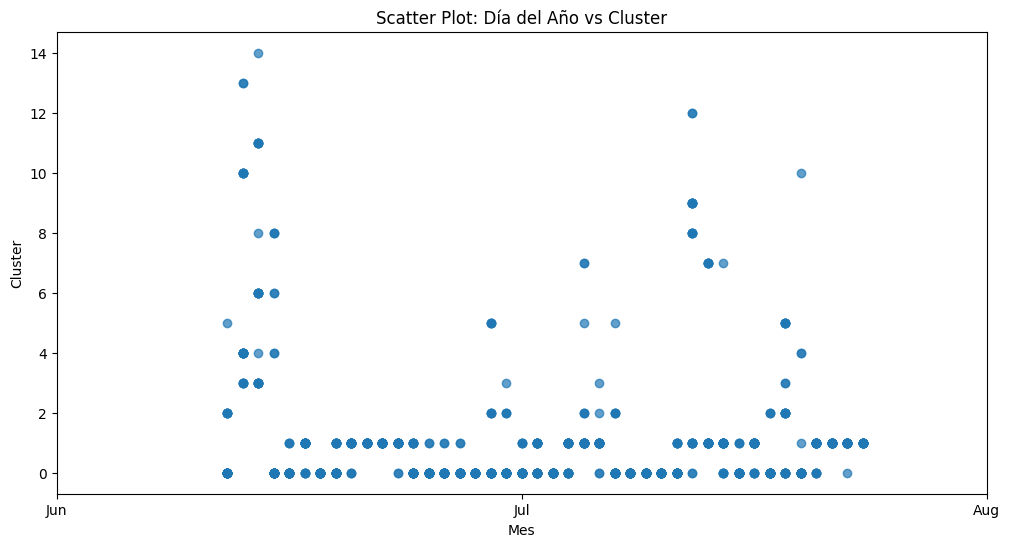

In [74]:
plt.figure(figsize=(12, 6))
plt.scatter(result_df['dia'], result_df['cluster'], alpha=0.7)



# Ajusta las etiquetas para que coincidan con los días del año
plt.title('Scatter Plot: Día del Año vs Cluster')
plt.xlabel('Mes')
plt.ylabel('Cluster')

# Agrega las etiquetas de los meses
plt.xticks(
    ticks=[15 + i * 30 for i in range(5, 8)],  # Aprox. posición para los meses
    labels=['Jun', 'Jul', 'Aug']
)

plt.show()